In [1]:
import torch
import torchvision
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pathlib import Path
from ast import literal_eval

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
path_to_weights = Path('/mnt/ml-team/homes/grzegorz.los/models/pretrained/resnet18-5c106cde.pth')
path_to_label_encoding = Path('/mnt/ml-team/homes/grzegorz.los/models/imagenet_classes.txt')
img_paths = list(Path('/mnt/ml-team/homes/grzegorz.los/pictures').glob('*'))

In [4]:
model = torchvision.models.resnet18(pretrained=False)
model.load_state_dict(torch.load(str(path_to_weights)))
model = model.to(device)

In [5]:
with open(str(path_to_label_encoding)) as file:
    code_to_label = literal_eval(file.read())

In [6]:
for k, v in list(code_to_label.items())[:4]:
    print('{}: {}'.format(k, v))
print('⋮')
for k, v in list(code_to_label.items())[-4:]:
    print('{}: {}'.format(k, v))

0: tench, Tinca tinca
1: goldfish, Carassius auratus
2: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
3: tiger shark, Galeocerdo cuvieri
⋮
996: hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa
997: bolete
998: ear, spike, capitulum
999: toilet tissue, toilet paper, bathroom tissue


In [7]:
def select_most_likely(preds, count=3):
    indices_sorted = np.argsort(preds)[::-1]
    return [(i, preds[i]) for i in indices_sorted[:count]]

def build_summary(preds, code_to_label, count=3, include_other=True):
    most_likely = select_most_likely(preds, count)
    
    lines = ["Predicted classes:\n"]
    
    for i, p in most_likely:
        lbl = code_to_label[i]
        lbl_parts = [lbl[i:i+40] for i in range(0, len(lbl), 40)]
        lines.append("  - {: >5.1%}: {}\n".format(p, '\n           '.join(lbl_parts)))
    
    if include_other:
        s = sum([p for _, p in most_likely])
        lines.append("  - {: >5.1%}: other\n".format(1 - s))
    
    return ''.join(lines)
    

def display_img_and_labels(img, preds, code_to_label, count=5, include_other=True):
    summary = build_summary(preds, code_to_label, count, include_other)
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2]) 
    plt.figure(figsize=(12, 6))
    plt.subplot(gs[0]).imshow(img_pil)
    plt.axis('off')
    plt.subplot(gs[1]).text(0.0, 0.50, summary, fontsize=16, fontname='monospace')
    plt.axis('off')
    #plt.tight_layout()
    plt.show()

def get_predictions(model: torch.nn.Module, img: Image, device: torch.device) -> np.ndarray:
    img_tensor = for_pytorch(img)
    img_tensor = img_tensor.to(device)
    img_tensor = img_tensor.unsqueeze(0)
    output = model(img_tensor)
    preds = torch.nn.Softmax(dim=1)(output)
    return preds.cpu().numpy().squeeze()

for_pytorch = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(  # https://pytorch.org/docs/stable/torchvision/models.html
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


image-174.jpeg
(474, 386)


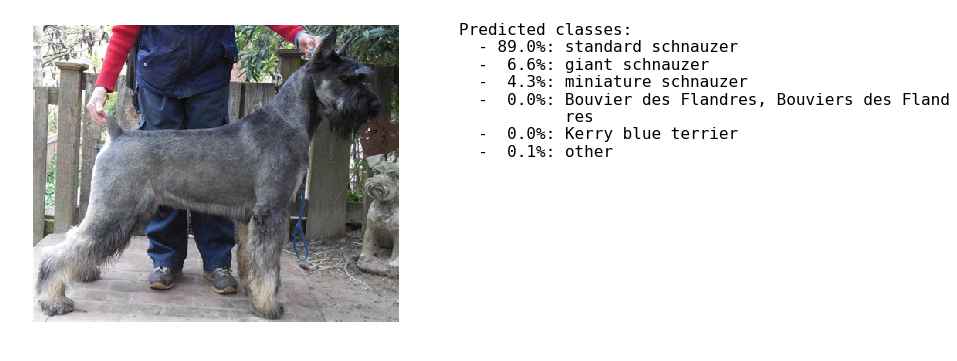

rottweiler.jpeg
(474, 632)


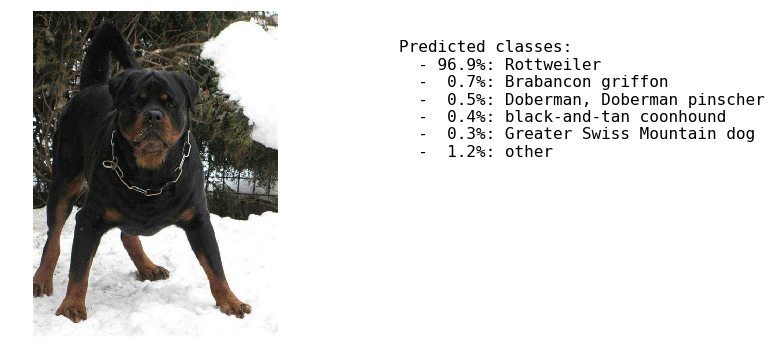

image-236.jpeg
(474, 355)


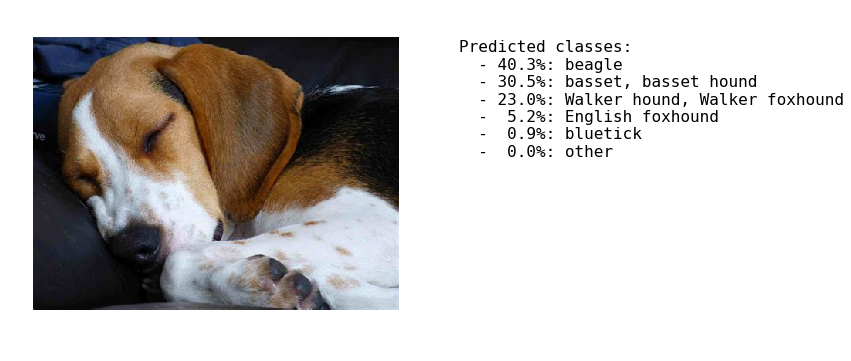

1200px-House_Sparrow_mar08.jpg
(1200, 800)


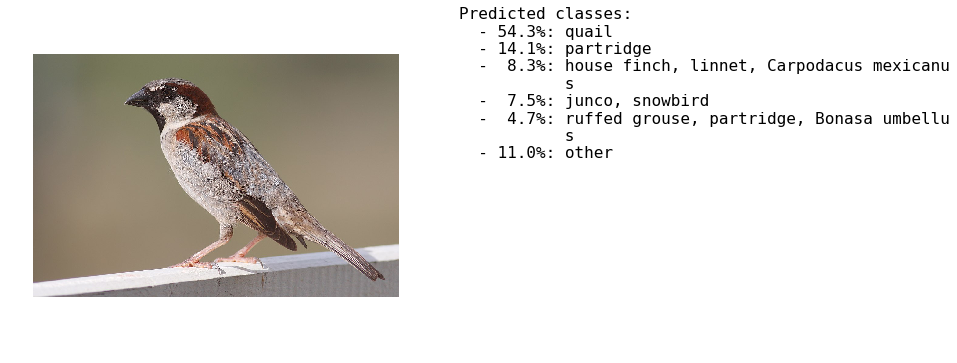

1200px-Jacare_de_papo_amarelo_zoo.jpg
(1200, 900)


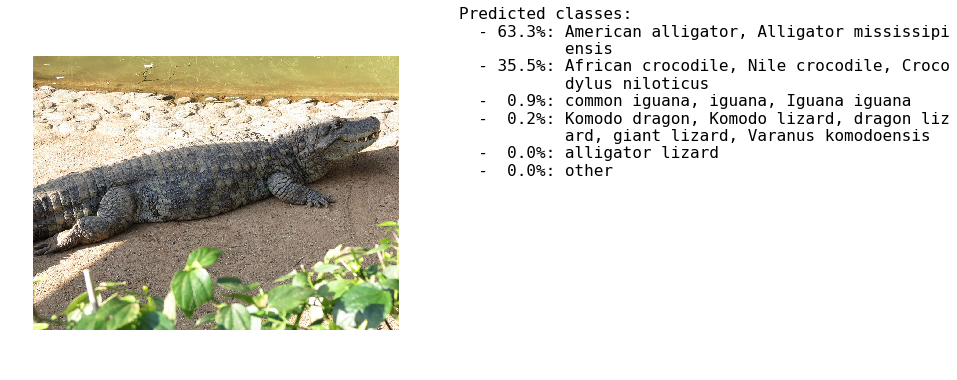

1200px-Korean_magpie_in_Daejeon_(side_profile).jpg
(1200, 800)


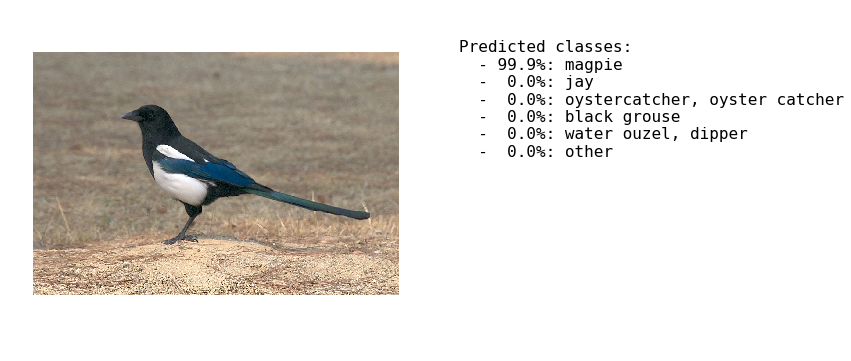

1200px-Magpie_arp.jpg
(1200, 1545)


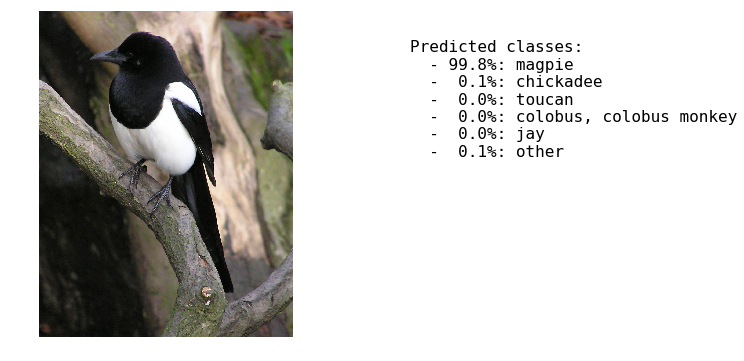

alligator-1024.jpg
(1024, 768)


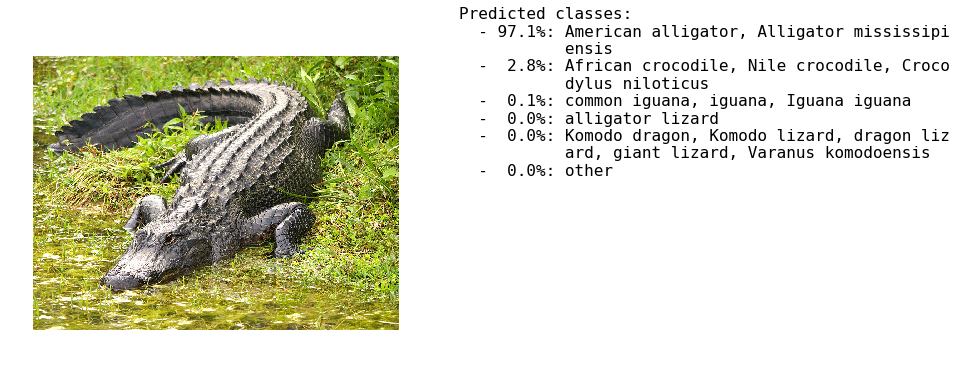

beef-cow.jpg
(400, 301)


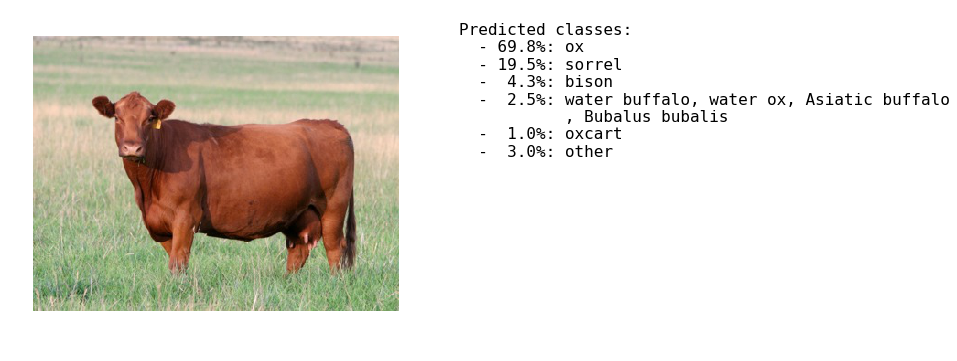

blue-jay-facts2.jpg
(1932, 1449)


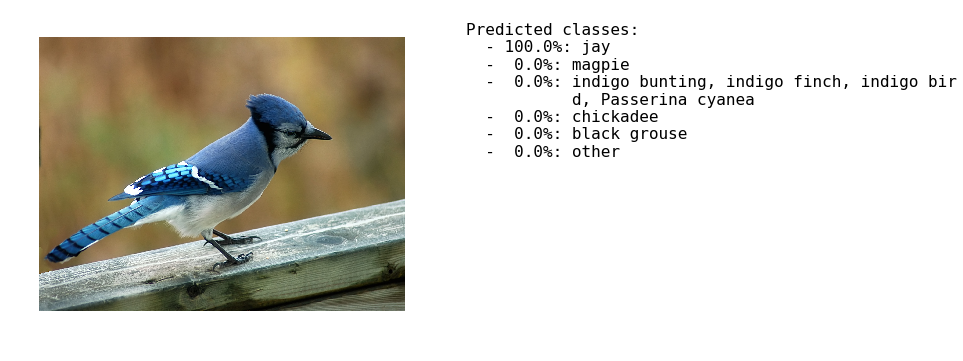

Common_raven_by_David_Hofmann.jpg
(1200, 1054)


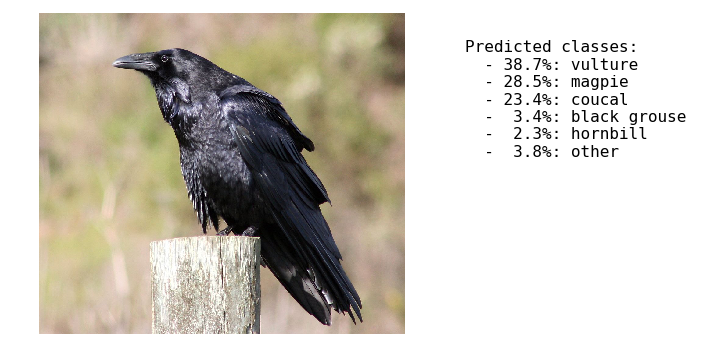

Crocodile-Dangerous-Animal.jpg
(1024, 768)


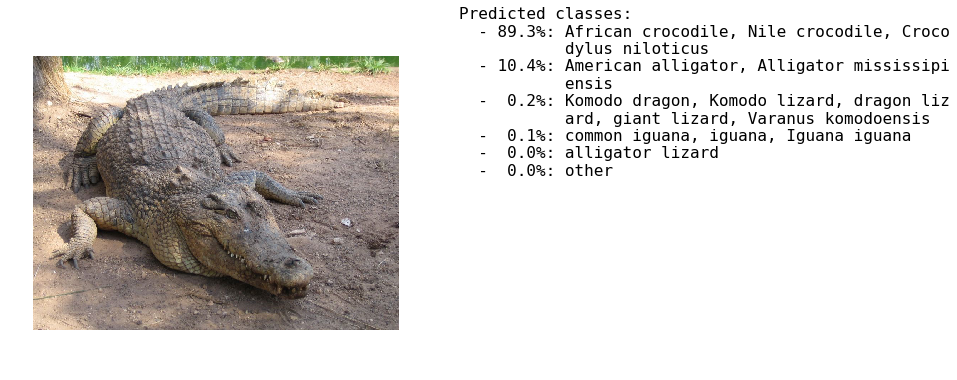

Fish_Crow_RWSinclair_FlickrCC_314.jpg
(2400, 1696)


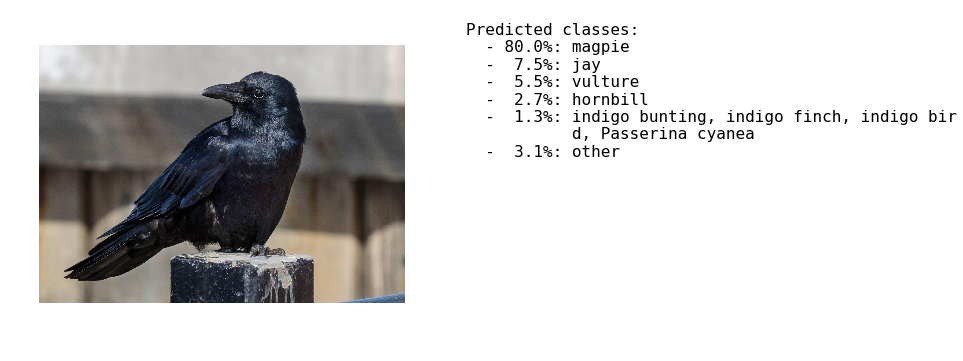

Glebogryzarka_spalinowa_Performance_Power_B_S_750-621624-142907.jpg
(650, 650)


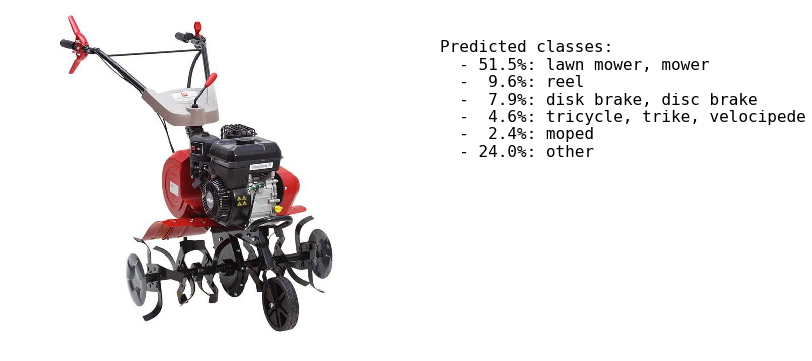

Holstein-Friesian-Cow.jpg
(450, 338)


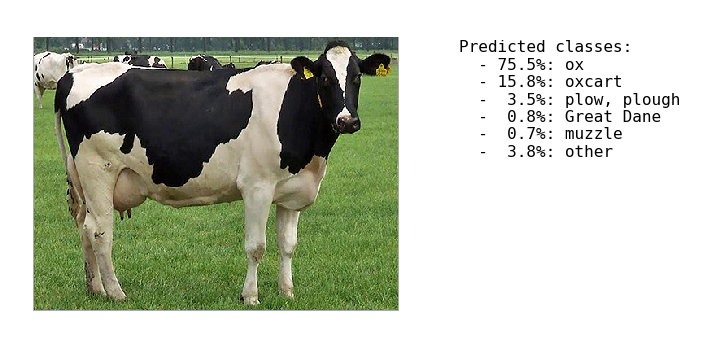

Horse Sea.jpg
(400, 300)


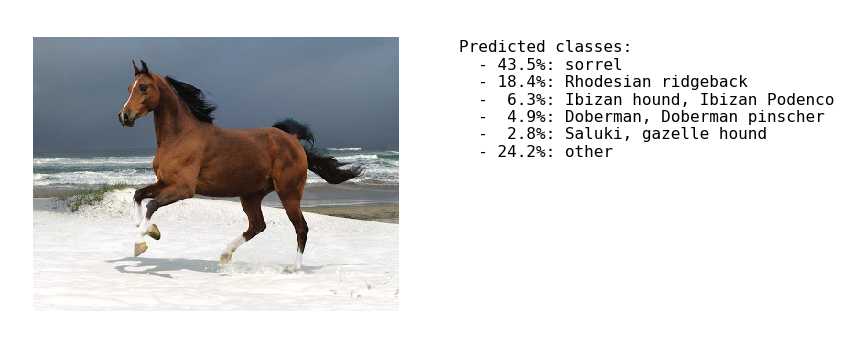

jackdaw_portrait.jpg
(1024, 683)


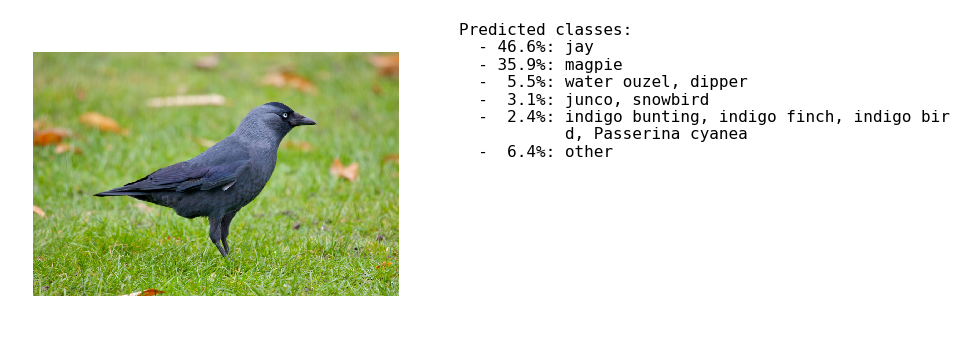

Jay-Garrulus-glandarius.jpg
(1220, 1220)


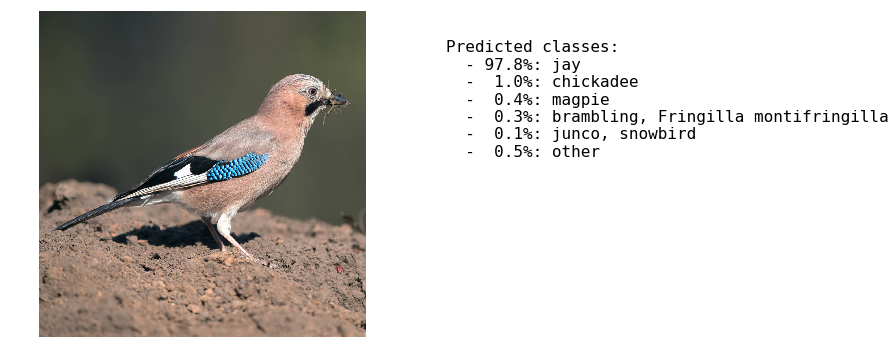

jersey.jpg
(350, 350)


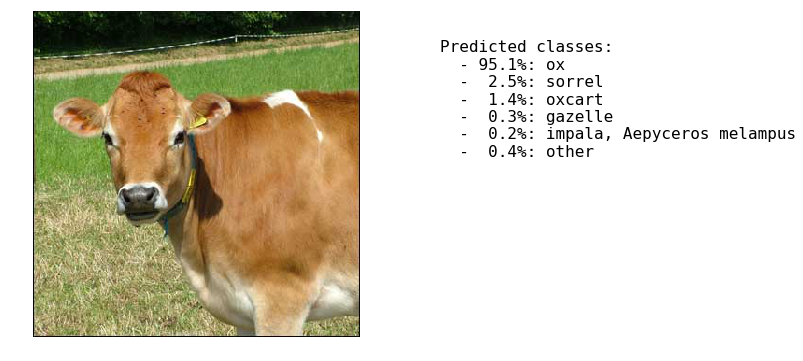

milka cow 2.jpg
(723, 640)


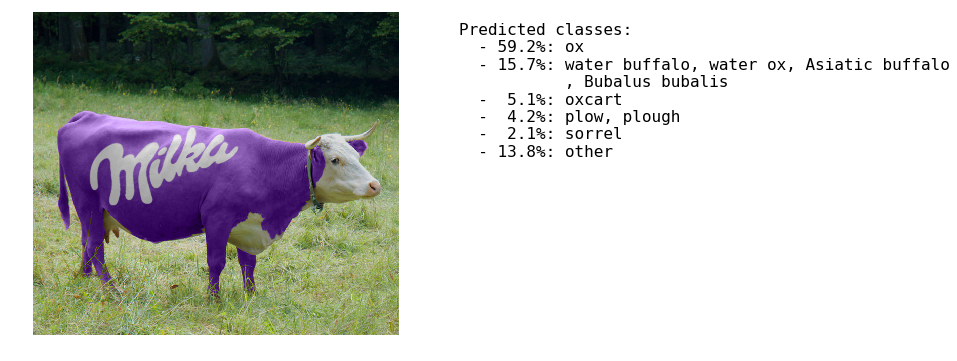

Nonius-Horse.jpg
(480, 360)


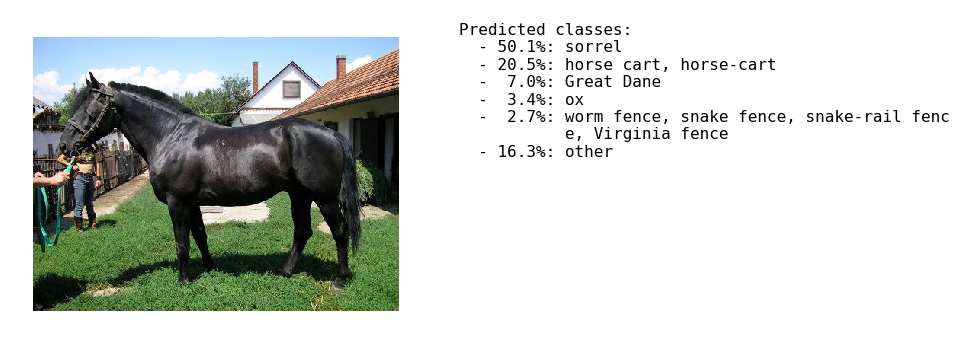

p15lm6h75hpvm17o417kksaa1q3la.jpg
(900, 983)


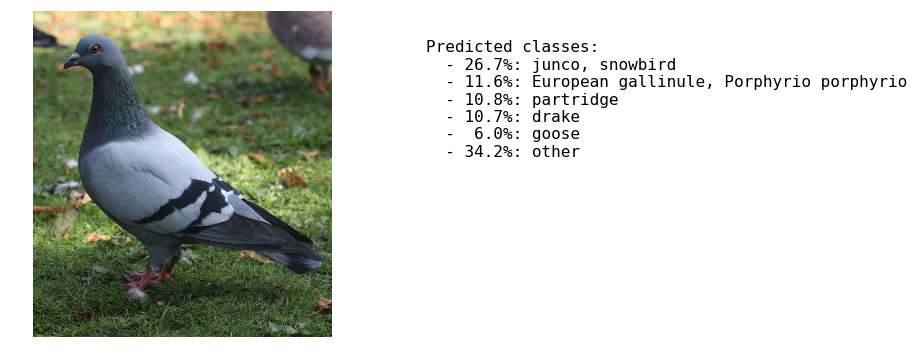

In [8]:
model.eval()
with torch.no_grad():
    for path in img_paths:
        print(path.name)
        img_pil = Image.open(path)
        print(img_pil.size)
        preds = get_predictions(model, img_pil, device)
        display_img_and_labels(img_pil, preds, code_to_label)